# 

#  <span style="color:lightblue" font="bold"> Baseline Tumor Categorization </span>

In [3]:
### Importing the necessary libraries

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

from PIL import Image

#### 1. <span style="color:lightblue" font="bold"> Loading the dataset </span>

In [4]:
# Define the path to the classification dataset (relative to the notebook location)
data_dir = Path("../raw_data/classification/Training")
test_dir = Path("../raw_data/classification/Testing")
os.listdir(data_dir)
os.listdir(test_dir)


['pituitary', '.DS_Store', 'notumor', 'glioma', 'meningioma']

##### OPTIONAL : Adding other images 

In [5]:
# FILE_PATH = Path("../raw_data/brain_tumor_df_processed.pkl")
# df_charge = pd.read_pickle(FILE_PATH)
# df_charge.head()

# df_charge.drop(columns=['tumorMask', 'PID', 'filename'], inplace= True)
# mapping = {
#     1: 'meningioma',
#     2: 'glioma',
#     3: 'pituitary'
# }

# df_charge["tumor_type_encoded"] = df_charge.label.map(mapping)

# # 1. Rename tumor_type_encoded -> tumor_type
# df_charge = df_charge.rename(columns={"tumor_type_encoded": "tumor_type"})

# # 2. Create new tumor_type_encoded from label
# df_charge["tumor_type_encoded"] = df_charge["label"]

# # 3. (Optional) Drop the old label column
# df_charge = df_charge.drop(columns=["label"])

# # 4. (Optional) Reorder columns exactly as you want
# df_charge = df_charge[["image", "tumor_type", "tumor_type_encoded"]]

# def resize_to_128(x):
#     x = np.array(x)
#     img = Image.fromarray(x)          # assume x is 2D grayscale
#     img = img.resize((128, 128))      # resize
#     arr = np.array(img)
#     return arr.reshape(128, 128, 1)   

# df_charge["image"] = df_charge["image"].apply(resize_to_128)
# df_charge.image = df_charge.image / 255.


#### 1.1 Removing duplicates

In [6]:
from pathlib import Path
import hashlib
import os

# --- Paramès ---
DATASET_ROOT = Path("../raw_data/classification")  # dossier racine contenant Training/ et Testing/
CLASSES = ["glioma", "pituitary", "meningioma", "notumor"]
SPLITS_ORDER = ["Training", "Testing"]  # Priorité : on garde ce qu'on voit en premier
EXTENSIONS = (".jpg", ".jpeg", ".png", ".bmp")  # adapte si besoin
DRY_RUN = False  # Mettre False pour réellement supprimer les fichiers

# ----------------------------

def file_hash(path, algo="md5", block_size=65536):
    """Hash du fichier basé sur son contenu (rapide et robuste pour duplicats exacts)."""
    h = hashlib.new(algo)
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(block_size), b""):
            h.update(chunk)
    return h.hexdigest()


def list_all_images():
    """Retourne la liste de tous les chemins d’images (Training + Testing, toutes classes)."""
    all_paths = []
    for split in SPLITS_ORDER:  # Training d'abord, puis Testing
        for cls in CLASSES:
            folder = DATASET_ROOT / split / cls
            if not folder.exists():
                print(f"⚠️ Dossier absent : {folder}")
                continue
            for ext in EXTENSIONS:
                all_paths.extend(folder.rglob(f"*{ext}"))
    return all_paths


def find_duplicates(paths):
    """
    Retourne:
        - hash_to_files: dict hash -> [liste des fichiers]
        - duplicates: liste de listes [fichier_à_garder, fichier_dup1, fichier_dup2, ...]
    """
    hash_to_files = {}
    for i, p in enumerate(paths, 1):
        if i % 500 == 0:
            print(f"Scanné {i} fichiers...")
        h = file_hash(p)
        hash_to_files.setdefault(h, []).append(p)

    duplicates_groups = []
    for h, files in hash_to_files.items():
        if len(files) > 1:
            # garder le premier (selon ordre SPLITS_ORDER)
            keep = files[0]
            dups = files[1:]
            duplicates_groups.append([keep] + dups)

    return hash_to_files, duplicates_groups


def main():
    print("🔍 Listing des images...")
    all_paths = list_all_images()
    print(f"Total d'images trouvées : {len(all_paths)}")

    print("🧮 Calcul des hash et recherche des doublons...")
    _, duplicates_groups = find_duplicates(all_paths)

    if not duplicates_groups:
        print("✅ Aucun doublon exact trouvé.")
        return

    total_dups = sum(len(g) - 1 for g in duplicates_groups)
    print(f"⚠️ Nombre de groupes de doublons : {len(duplicates_groups)}")
    print(f"⚠️ Nombre total de fichiers en trop : {total_dups}\n")

    # Afficher un aperçu
    print("Exemple de groupe de doublons :")
    for g in duplicates_groups[:3]:  # maximum 3 groupes affichés
        print("  À garder :", g[0])
        for d in g[1:]:
            print("    Doublon :", d)
        print()

    if DRY_RUN:
        print("Mode DRY_RUN = True : aucun fichier ne sera supprimé.")
        print("Si tout te semble OK, passe DRY_RUN à False et relance.")
        return

    # Suppression effective
    print("🗑 Suppression des doublons...")
    deleted = 0
    for group in duplicates_groups:
        to_delete = group[1:]  # on garde group[0]
        for f in to_delete:
            try:
                os.remove(f)
                deleted += 1
            except Exception as e:
                print(f"Erreur en supprimant {f}: {e}")

    print(f"✅ Suppression terminée. Fichiers supprimés : {deleted}")


# if __name__ == "__main__":
main()

🔍 Listing des images...
Total d'images trouvées : 13899
🧮 Calcul des hash et recherche des doublons...
Scanné 500 fichiers...
Scanné 1000 fichiers...
Scanné 1500 fichiers...
Scanné 2000 fichiers...
Scanné 2500 fichiers...
Scanné 3000 fichiers...
Scanné 3500 fichiers...
Scanné 4000 fichiers...
Scanné 4500 fichiers...
Scanné 5000 fichiers...
Scanné 5500 fichiers...
Scanné 6000 fichiers...
Scanné 6500 fichiers...
Scanné 7000 fichiers...
Scanné 7500 fichiers...
Scanné 8000 fichiers...
Scanné 8500 fichiers...
Scanné 9000 fichiers...
Scanné 9500 fichiers...
Scanné 10000 fichiers...
Scanné 10500 fichiers...
Scanné 11000 fichiers...
Scanné 11500 fichiers...
Scanné 12000 fichiers...
Scanné 12500 fichiers...
Scanné 13000 fichiers...
Scanné 13500 fichiers...
✅ Aucun doublon exact trouvé.


##### 1.2 Creating a dataframe of images paths and labels

In [7]:
# Collect image paths and their corresponding tumor types
image_paths = []
labels = []

for tumor_type in os.listdir(data_dir):
    tumor_type_path = data_dir/tumor_type
    if os.path.isdir(tumor_type_path):
        for img_name in os.listdir(tumor_type_path):
            img_path = tumor_type_path / img_name
            # Optional: filter only image files
            if img_path.suffix.lower() in [".png", ".jpg", ".jpeg"]:
                image_paths.append(str(img_path))
                labels.append(tumor_type)

# Create a DataFrame for the dataset
df = pd.DataFrame({
    "image_path": image_paths,
    "tumor_type": labels
})

# Show the first few rows for verification
print(df.shape)
df.head(10)


(11410, 2)


,image_path,tumor_type
0,../raw_data/classification/Training/pituitary/...,pituitary
1,../raw_data/classification/Training/pituitary/...,pituitary
2,../raw_data/classification/Training/pituitary/...,pituitary
3,../raw_data/classification/Training/pituitary/...,pituitary
4,../raw_data/classification/Training/pituitary/...,pituitary
5,../raw_data/classification/Training/pituitary/...,pituitary
6,../raw_data/classification/Training/pituitary/...,pituitary
7,../raw_data/classification/Training/pituitary/...,pituitary
8,../raw_data/classification/Training/pituitary/...,pituitary
9,../raw_data/classification/Training/pituitary/...,pituitary


#### 2. One-hot Encoding Tumor Types

In [8]:
# One-hot encoding the tumor types
mapping = {
    'notumor': 0,
    'meningioma': 1,
    'glioma': 2,
    'pituitary': 3
}

df["tumor_type_encoded"] = df["tumor_type"].map(mapping)
df.head()

,image_path,tumor_type,tumor_type_encoded
0,../raw_data/classification/Training/pituitary/...,pituitary,3
1,../raw_data/classification/Training/pituitary/...,pituitary,3
2,../raw_data/classification/Training/pituitary/...,pituitary,3
3,../raw_data/classification/Training/pituitary/...,pituitary,3
4,../raw_data/classification/Training/pituitary/...,pituitary,3


#### 3. First Model Training

#####        3.1 Define image loading function and the training / validation sets

In [9]:
from tensorflow.lite.python import convert
def load_image(path):
    img = Image.open(path).convert("L")
    arr = np.array(img, dtype=np.float32)
    return arr

In [10]:
def load_process_image(path):
    img = Image.open(path).convert("L")
    img = img.resize(size=(256, 256))
    arr = np.array(img, dtype=np.float32)
    arr = arr / 255.
    return arr

In [11]:
X_paths = df.image_path
X = X_paths.apply(lambda x : load_process_image(x))
X = np.stack(X, axis=0) 
X = X.reshape(-1, 256, 256, 1)
print("X shape :", X.shape)

X shape : (11410, 256, 256, 1)


In [12]:
y = df.tumor_type_encoded
print("y shape :", y.shape)

y shape : (11410,)


In [13]:
df['image'] = list(X)
col = df.pop("image")        # remove "C" and get its Series
df.insert(0, "image", col)   # insert at position 0 (first)
df.drop(columns='image_path', inplace=True)

In [14]:
df.shape

(11410, 3)

<Axes: xlabel='tumor_type', ylabel='count'>

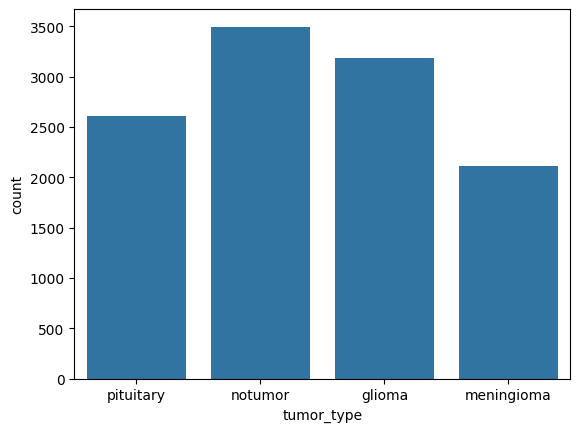

In [15]:
sns.countplot(x="tumor_type", data=df)

#### 3. Definie model

In [16]:
def init_baseline(input_shape, num_classes=4):
    model = Sequential()
    model.add(Input(shape=input_shape))

    # Block 1
    model.add(layers.Conv2D(32, (3, 3),
                            padding='same',
                            activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    # Block 2
    model.add(layers.Conv2D(64, (3, 3),
                            padding='same',
                            activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    # Global pooling instead of Flatten
    model.add(layers.GlobalAveragePooling2D())

    # Small dense head
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [17]:
from tensorflow.keras.metrics import Recall

def compile_model(model):
    '''return a compiled model suited for the CIFAR-10 task'''
    model.compile(optimizer= 'adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=["accuracy"])
    return model


In [18]:
model = init_baseline(input_shape=X.shape[1:], num_classes=4)

2025-12-03 10:24:15.718252: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-12-03 10:24:15.718278: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-12-03 10:24:15.718289: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-12-03 10:24:15.718314: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-03 10:24:15.718327: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 global_average_pooling2d (  (None, 64)                0         
 GlobalAveragePooling2D)                                         
                                                        

In [20]:
model = compile_model(model)
es = EarlyStopping(patience=3, restore_best_weights=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

# Set memory growth on all available GPUs

import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))


history = model.fit(X_train, y_train,
                        epochs=5,
                        batch_size=64,
                        validation_data= (X_val, y_val),
                        verbose=1,
                        callbacks=[es])

TensorFlow version: 2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/5


2025-12-03 10:24:19.033016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 14s 97ms/step - loss: 1.3272 - accuracy: 0.3555 - val_loss: 1.2538 - val_accuracy: 0.4616
Epoch 2/5
125/125 [==============================] - 11s 88ms/step - loss: 1.2360 - accuracy: 0.4515 - val_loss: 1.2084 - val_accuracy: 0.4619
Epoch 3/5
125/125 [==============================] - 11s 86ms/step - loss: 1.1900 - accuracy: 0.4844 - val_loss: 1.1321 - val_accuracy: 0.5668
Epoch 4/5
125/125 [==============================] - 11s 87ms/step - loss: 1.1586 - accuracy: 0.5206 - val_loss: 1.1005 - val_accuracy: 0.5808
Epoch 5/5
125/125 [==============================] - 11s 86ms/step - loss: 1.1247 - accuracy: 0.5372 - val_loss: 1.0982 - val_accuracy: 0.5565


(2495, 2)


<Axes: xlabel='test_tumor_type', ylabel='count'>

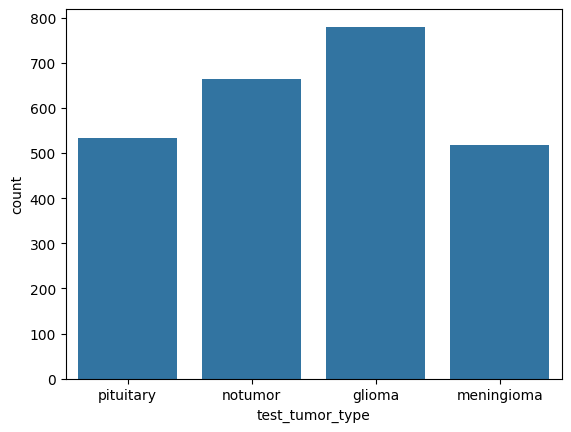

In [21]:
# Collect image paths and their corresponding tumor types
from scipy import test


test_paths = []
test_labels = []

for tumor_type in os.listdir(test_dir):
    tumor_type_path = test_dir/tumor_type
    if os.path.isdir(tumor_type_path):
        for test_img_name in os.listdir(tumor_type_path):
            test_img_path = tumor_type_path / test_img_name
            # Optional: filter only image files
            if test_img_path.suffix.lower() in [".png", ".jpg", ".jpeg"]:
                test_paths.append(str(test_img_path))
                test_labels.append(tumor_type)

# Create a DataFrame for the dataset
test_df = pd.DataFrame({
    "test_image_path": test_paths,
    "test_tumor_type": test_labels
})

# Show the first few rows for verification
print(test_df.shape)
test_df.head(10)

sns.countplot(x="test_tumor_type", data=test_df)

In [22]:
test_df

,test_image_path,test_tumor_type
0,../raw_data/classification/Testing/pituitary/B...,pituitary
1,../raw_data/classification/Testing/pituitary/T...,pituitary
2,../raw_data/classification/Testing/pituitary/T...,pituitary
3,../raw_data/classification/Testing/pituitary/B...,pituitary
4,../raw_data/classification/Testing/pituitary/M...,pituitary
...,...,...
2490,../raw_data/classification/Testing/meningioma/...,meningioma
2491,../raw_data/classification/Testing/meningioma/...,meningioma
2492,../raw_data/classification/Testing/meningioma/...,meningioma
2493,../raw_data/classification/Testing/meningioma/...,meningioma


In [23]:
# One-hot encoding the tumor types
mapping = {
    'notumor': 0,
    'meningioma': 1,
    'glioma': 2,
    'pituitary': 3
}

test_df["test_tumor_type_encoded"] = test_df["test_tumor_type"].map(mapping)
test_df

,test_image_path,test_tumor_type,test_tumor_type_encoded
0,../raw_data/classification/Testing/pituitary/B...,pituitary,3
1,../raw_data/classification/Testing/pituitary/T...,pituitary,3
2,../raw_data/classification/Testing/pituitary/T...,pituitary,3
3,../raw_data/classification/Testing/pituitary/B...,pituitary,3
4,../raw_data/classification/Testing/pituitary/M...,pituitary,3
...,...,...,...
2490,../raw_data/classification/Testing/meningioma/...,meningioma,1
2491,../raw_data/classification/Testing/meningioma/...,meningioma,1
2492,../raw_data/classification/Testing/meningioma/...,meningioma,1
2493,../raw_data/classification/Testing/meningioma/...,meningioma,1


In [24]:
# Define the test set
X_test_paths = test_df.test_image_path
X_test = X_test_paths.apply(lambda X_test : load_process_image(X_test))
X_test = np.stack(X_test, axis=0) 
X_test = X_test.reshape(-1, 256, 256, 1)

y_test = test_df.test_tumor_type_encoded

print(y_test.shape, X_test.shape)

(2495,) (2495, 256, 256, 1)


In [25]:
y_test

0       3
1       3
2       3
3       3
4       3
       ..
2490    1
2491    1
2492    1
2493    1
2494    1
Name: test_tumor_type_encoded, Length: 2495, dtype: int64

In [26]:
results = model.evaluate(X_test, y_test, batch_size=32)
results

78/78 [==============================] - 1s 10ms/step - loss: 1.1008 - accuracy: 0.5695


[1.1008002758026123, 0.5695390701293945]

In [27]:
y_pred = model.predict(X_test)

78/78 [==============================] - 1s 9ms/step


In [28]:
np.argmax(y_pred, axis=1)


array([3, 3, 3, ..., 2, 2, 2])

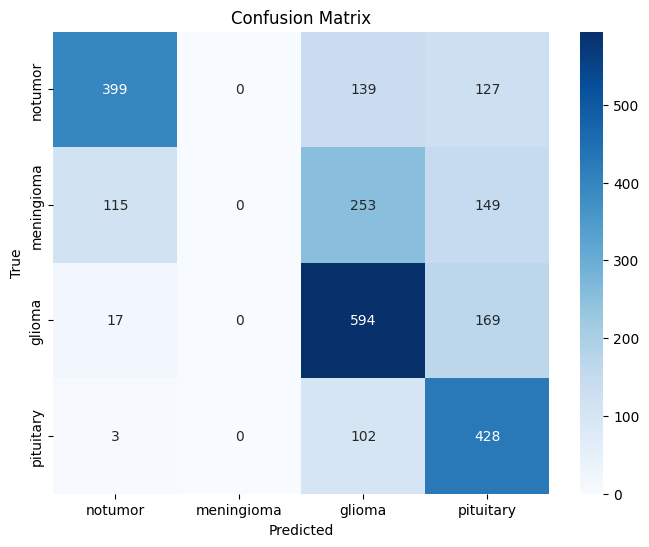

In [29]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true=y_test, y_pred=np.argmax(y_pred, axis=1))
plt.figure(figsize=(8, 6))
tumor_type_labels = ['notumor', 'meningioma', 'glioma', 'pituitary']
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=tumor_type_labels, yticklabels=tumor_type_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#### 4. Fine-tune categorization model

In [30]:
X_train.shape
X_train = X_train * 255.

In [38]:
IMG_SIZE = (256, 256)
NUM_CLASSES = 4
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Small data augmentation pipeline
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.1, 0.1),
    ],
    name="data_augmentation",
)

def create_transfer_model(input_shape=IMG_SIZE + (1,), num_classes=NUM_CLASSES):

    # Base model expects 3 channels
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=IMG_SIZE + (3,),
        pooling='avg'
    )
    base_model.trainable = False  # freeze at first

    inputs = Input(shape=input_shape)       # (256, 256, 1)
    x = data_augmentation(inputs)          # still (256, 256, 1)

    # Convert grayscale -> 3 channels AFTER augmentation
    x = tf.repeat(x, repeats=3, axis=-1)   # (256, 256, 3)

    # EfficientNet preprocessing (expects 0–255 input)
    x = tf.keras.applications.efficientnet.preprocess_input(x)

    # Pass through the base model
    x = base_model(x, training=False)

    # Classification head
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model


transfer_model = create_transfer_model()
transfer_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',  # y_train must be int labels 0..3
                       metrics=['accuracy'])

history = transfer_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True)],
    verbose = 1)


Epoch 1/10


2025-12-03 10:32:37.883455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/250 [..............................] - ETA: 20s - loss: 1.4325 - accuracy: 0.3438 

2025-12-03 10:32:38.637673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:38.719812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:38.800747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/250 [..............................] - ETA: 19s - loss: 1.3930 - accuracy: 0.3750

2025-12-03 10:32:38.881502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:38.961312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:39.042088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/250 [>.............................] - ETA: 19s - loss: 1.3811 - accuracy: 0.3438

2025-12-03 10:32:39.122454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:39.202837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:39.283598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/250 [>.............................] - ETA: 19s - loss: 1.3333 - accuracy: 0.3776

2025-12-03 10:32:39.364602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:39.444930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:39.525005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/250 [>.............................] - ETA: 18s - loss: 1.2885 - accuracy: 0.4167

2025-12-03 10:32:39.605587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:39.687030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:39.767515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/250 [=>............................] - ETA: 18s - loss: 1.2539 - accuracy: 0.4479

2025-12-03 10:32:39.848185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:39.928758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:40.008440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/250 [=>............................] - ETA: 18s - loss: 1.2240 - accuracy: 0.4702

2025-12-03 10:32:40.088464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:40.168604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:40.248810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/250 [=>............................] - ETA: 18s - loss: 1.2092 - accuracy: 0.4779

2025-12-03 10:32:40.329221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:40.411408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:40.492883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/250 [==>...........................] - ETA: 17s - loss: 1.1789 - accuracy: 0.4954

2025-12-03 10:32:40.573728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:40.654097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:40.734251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/250 [==>...........................] - ETA: 17s - loss: 1.1673 - accuracy: 0.5031

2025-12-03 10:32:40.815195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:40.895295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:40.975768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/250 [==>...........................] - ETA: 17s - loss: 1.1426 - accuracy: 0.5170

2025-12-03 10:32:41.055496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:41.136229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:41.215404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/250 [===>..........................] - ETA: 17s - loss: 1.1220 - accuracy: 0.5286

2025-12-03 10:32:41.295267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:41.374694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:41.454814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/250 [===>..........................] - ETA: 16s - loss: 1.1100 - accuracy: 0.5329

2025-12-03 10:32:41.536292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:41.616547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:41.695910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/250 [====>.........................] - ETA: 16s - loss: 1.1009 - accuracy: 0.5342

2025-12-03 10:32:41.776710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:41.866451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:41.949210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/250 [====>.........................] - ETA: 16s - loss: 1.0865 - accuracy: 0.5437

2025-12-03 10:32:42.030440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:42.111351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:42.190938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/250 [====>.........................] - ETA: 16s - loss: 1.0701 - accuracy: 0.5527

2025-12-03 10:32:42.271948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:42.352737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:42.432760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/250 [=====>........................] - ETA: 16s - loss: 1.0573 - accuracy: 0.5588

2025-12-03 10:32:42.512091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:42.593538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:42.673311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/250 [=====>........................] - ETA: 15s - loss: 1.0417 - accuracy: 0.5660

2025-12-03 10:32:42.752960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:42.832685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:42.912982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/250 [=====>........................] - ETA: 15s - loss: 1.0265 - accuracy: 0.5746

2025-12-03 10:32:42.992867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:43.072741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:43.153652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/250 [======>.......................] - ETA: 15s - loss: 1.0166 - accuracy: 0.5802

2025-12-03 10:32:43.233554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:43.314347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:43.394159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/250 [======>.......................] - ETA: 15s - loss: 1.0049 - accuracy: 0.5863

2025-12-03 10:32:43.473959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:43.554014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:43.634635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/250 [======>.......................] - ETA: 14s - loss: 0.9917 - accuracy: 0.5938

2025-12-03 10:32:43.715507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:43.795325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:43.875550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/250 [=======>......................] - ETA: 14s - loss: 0.9795 - accuracy: 0.6005

2025-12-03 10:32:43.956273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:44.035954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:44.116257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/250 [=======>......................] - ETA: 14s - loss: 0.9689 - accuracy: 0.6059

2025-12-03 10:32:44.197091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:44.277286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:44.358332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/250 [========>.....................] - ETA: 14s - loss: 0.9588 - accuracy: 0.6112

2025-12-03 10:32:44.438482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:44.519724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:44.599819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/250 [========>.....................] - ETA: 13s - loss: 0.9513 - accuracy: 0.6154

2025-12-03 10:32:44.680203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:44.761033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:44.841125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/250 [========>.....................] - ETA: 13s - loss: 0.9423 - accuracy: 0.6208

2025-12-03 10:32:44.920736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:45.000504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:45.080886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/250 [=========>....................] - ETA: 13s - loss: 0.9344 - accuracy: 0.6254

2025-12-03 10:32:45.161427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:45.242717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:45.350483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/250 [=========>....................] - ETA: 13s - loss: 0.9266 - accuracy: 0.6286

2025-12-03 10:32:45.430740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:45.511143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:45.591501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/250 [=========>....................] - ETA: 12s - loss: 0.9192 - accuracy: 0.6330

2025-12-03 10:32:45.675021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:45.760573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:45.847034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/250 [==========>...................] - ETA: 12s - loss: 0.9111 - accuracy: 0.6374

2025-12-03 10:32:45.935015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:46.019747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:46.106184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/250 [==========>...................] - ETA: 12s - loss: 0.9029 - accuracy: 0.6406

2025-12-03 10:32:46.191243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:46.278285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:46.365457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/250 [==========>...................] - ETA: 12s - loss: 0.8922 - accuracy: 0.6455

2025-12-03 10:32:46.448747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:46.530256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:46.611863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/250 [===========>..................] - ETA: 12s - loss: 0.8841 - accuracy: 0.6498

2025-12-03 10:32:46.691912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:46.778037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:46.865245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/250 [===========>..................] - ETA: 11s - loss: 0.8802 - accuracy: 0.6518

2025-12-03 10:32:46.951443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:47.035490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:47.120376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/250 [===========>..................] - ETA: 11s - loss: 0.8724 - accuracy: 0.6568

2025-12-03 10:32:47.204790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:47.285638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:47.367353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/250 [============>.................] - ETA: 11s - loss: 0.8657 - accuracy: 0.6605

2025-12-03 10:32:47.449199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:47.530757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:47.614845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/250 [============>.................] - ETA: 11s - loss: 0.8588 - accuracy: 0.6637

2025-12-03 10:32:47.706777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:47.795416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:47.876745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/250 [=============>................] - ETA: 10s - loss: 0.8522 - accuracy: 0.6669

2025-12-03 10:32:47.958349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:48.040411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:48.121190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/250 [=============>................] - ETA: 10s - loss: 0.8448 - accuracy: 0.6701

2025-12-03 10:32:48.204181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:48.295657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:48.385630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/250 [=============>................] - ETA: 10s - loss: 0.8400 - accuracy: 0.6720

2025-12-03 10:32:48.466986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:48.550094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:48.631059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/250 [==============>...............] - ETA: 10s - loss: 0.8377 - accuracy: 0.6719

2025-12-03 10:32:48.712985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:48.795736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:48.877450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/250 [==============>...............] - ETA: 9s - loss: 0.8340 - accuracy: 0.6734

2025-12-03 10:32:48.959650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:49.041047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:49.121023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/250 [==============>...............] - ETA: 9s - loss: 0.8294 - accuracy: 0.6752

2025-12-03 10:32:49.202301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:49.283877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:49.365726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/250 [===============>..............] - ETA: 9s - loss: 0.8224 - accuracy: 0.6792

2025-12-03 10:32:49.446085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:49.527719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:49.608744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/250 [===============>..............] - ETA: 9s - loss: 0.8164 - accuracy: 0.6825

2025-12-03 10:32:49.689400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:49.771363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:49.852544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/250 [===============>..............] - ETA: 8s - loss: 0.8102 - accuracy: 0.6866

2025-12-03 10:32:49.934211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:50.015607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:50.098994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/250 [================>.............] - ETA: 8s - loss: 0.8069 - accuracy: 0.6884

2025-12-03 10:32:50.183443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:50.265880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:50.347700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/250 [================>.............] - ETA: 8s - loss: 0.8046 - accuracy: 0.6888

2025-12-03 10:32:50.428985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:50.510681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:50.591599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/250 [=================>............] - ETA: 8s - loss: 0.8005 - accuracy: 0.6904

2025-12-03 10:32:50.672560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:50.754067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:50.835769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/250 [=================>............] - ETA: 7s - loss: 0.7960 - accuracy: 0.6926

2025-12-03 10:32:50.917112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:50.999398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:51.080077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/250 [=================>............] - ETA: 7s - loss: 0.7924 - accuracy: 0.6943

2025-12-03 10:32:51.160358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:51.242307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:51.323421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/250 [==================>...........] - ETA: 7s - loss: 0.7892 - accuracy: 0.6956

2025-12-03 10:32:51.405673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:51.487059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:51.567863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/250 [==================>...........] - ETA: 7s - loss: 0.7867 - accuracy: 0.6958

2025-12-03 10:32:51.652247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:51.737356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:51.823328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/250 [==================>...........] - ETA: 6s - loss: 0.7819 - accuracy: 0.6973

2025-12-03 10:32:51.909484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:51.993360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:52.076414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/250 [===================>..........] - ETA: 6s - loss: 0.7784 - accuracy: 0.6988

2025-12-03 10:32:52.161994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:52.248651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:52.334318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/250 [===================>..........] - ETA: 6s - loss: 0.7746 - accuracy: 0.7008

2025-12-03 10:32:52.421085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:52.516282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:52.607383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/250 [===================>..........] - ETA: 6s - loss: 0.7722 - accuracy: 0.7026

2025-12-03 10:32:52.689788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:52.771732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:52.853210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/250 [====================>.........] - ETA: 5s - loss: 0.7682 - accuracy: 0.7044

2025-12-03 10:32:52.934708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:53.016081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:53.098126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/250 [====================>.........] - ETA: 5s - loss: 0.7653 - accuracy: 0.7056

2025-12-03 10:32:53.183230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:53.269038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:53.355349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/250 [====================>.........] - ETA: 5s - loss: 0.7631 - accuracy: 0.7061

2025-12-03 10:32:53.441382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:53.526350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:53.610696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/250 [=====================>........] - ETA: 5s - loss: 0.7599 - accuracy: 0.7068

2025-12-03 10:32:53.698523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:53.785401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:53.868128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/250 [=====================>........] - ETA: 5s - loss: 0.7579 - accuracy: 0.7075

2025-12-03 10:32:53.949272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:54.031438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:54.112467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/250 [======================>.......] - ETA: 4s - loss: 0.7571 - accuracy: 0.7082

2025-12-03 10:32:54.194450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:54.275363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:54.356513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/250 [======================>.......] - ETA: 4s - loss: 0.7541 - accuracy: 0.7098

2025-12-03 10:32:54.437226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:54.518260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:54.599036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/250 [======================>.......] - ETA: 4s - loss: 0.7504 - accuracy: 0.7115

2025-12-03 10:32:54.680172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:54.762335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:54.843934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/250 [=======================>......] - ETA: 4s - loss: 0.7493 - accuracy: 0.7121

2025-12-03 10:32:54.925172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:55.007953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:55.088653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/250 [=======================>......] - ETA: 3s - loss: 0.7462 - accuracy: 0.7138

2025-12-03 10:32:55.170048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:55.251179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:55.332938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/250 [=======================>......] - ETA: 3s - loss: 0.7427 - accuracy: 0.7153

2025-12-03 10:32:55.413604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:55.495062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:55.576002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/250 [========================>.....] - ETA: 3s - loss: 0.7386 - accuracy: 0.7170

2025-12-03 10:32:55.661096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:55.743838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:55.825564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/250 [========================>.....] - ETA: 3s - loss: 0.7353 - accuracy: 0.7185

2025-12-03 10:32:55.906824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:55.987545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:56.068096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/250 [========================>.....] - ETA: 2s - loss: 0.7319 - accuracy: 0.7203

2025-12-03 10:32:56.151156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:56.239620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:56.328183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/250 [=========================>....] - ETA: 2s - loss: 0.7283 - accuracy: 0.7217

2025-12-03 10:32:56.410959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:56.493371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:56.577001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/250 [=========================>....] - ETA: 2s - loss: 0.7271 - accuracy: 0.7224

2025-12-03 10:32:56.658382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:56.741594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:56.823734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/250 [==========================>...] - ETA: 2s - loss: 0.7248 - accuracy: 0.7236

2025-12-03 10:32:56.905613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:56.987646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:57.068294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/250 [==========================>...] - ETA: 1s - loss: 0.7215 - accuracy: 0.7253

2025-12-03 10:32:57.150310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:57.232633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:57.313399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/250 [==========================>...] - ETA: 1s - loss: 0.7196 - accuracy: 0.7265

2025-12-03 10:32:57.395736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:57.478386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:57.563948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/250 [===========================>..] - ETA: 1s - loss: 0.7164 - accuracy: 0.7284

2025-12-03 10:32:57.654132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:57.746872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:57.835723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/250 [===========================>..] - ETA: 1s - loss: 0.7143 - accuracy: 0.7290

2025-12-03 10:32:57.924011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:58.004845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:58.085588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/250 [===========================>..] - ETA: 0s - loss: 0.7117 - accuracy: 0.7301

2025-12-03 10:32:58.165351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:58.258834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:58.343696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/250 [============================>.] - ETA: 0s - loss: 0.7100 - accuracy: 0.7307

2025-12-03 10:32:58.427035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:58.511772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:58.592279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/250 [============================>.] - ETA: 0s - loss: 0.7086 - accuracy: 0.7307

2025-12-03 10:32:58.674335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:58.765998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:58.854693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/250 [============================>.] - ETA: 0s - loss: 0.7059 - accuracy: 0.7321

2025-12-03 10:32:58.942180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:59.026743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:32:59.114276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/250 [==============================] - 33s 121ms/step - loss: 0.7055 - accuracy: 0.7323 - val_loss: 1.9242 - val_accuracy: 0.2708
Epoch 2/10
  2/250 [..............................] - ETA: 20s - loss: 0.5111 - accuracy: 0.8281

2025-12-03 10:33:08.862175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:08.980925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:09.062386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/250 [..............................] - ETA: 20s - loss: 0.5524 - accuracy: 0.7750

2025-12-03 10:33:09.144417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:09.225948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:09.308025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/250 [..............................] - ETA: 19s - loss: 0.5335 - accuracy: 0.7930

2025-12-03 10:33:09.389733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:09.473689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:09.556862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/250 [>.............................] - ETA: 19s - loss: 0.4898 - accuracy: 0.8295

2025-12-03 10:33:09.640392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:09.723944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:09.805817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/250 [>.............................] - ETA: 19s - loss: 0.4967 - accuracy: 0.8259

2025-12-03 10:33:09.888483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:09.972039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:10.054325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/250 [=>............................] - ETA: 19s - loss: 0.5004 - accuracy: 0.8254

2025-12-03 10:33:10.137887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:10.221678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:10.307367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/250 [=>............................] - ETA: 19s - loss: 0.5139 - accuracy: 0.8219

2025-12-03 10:33:10.392303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:10.477657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:10.559568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/250 [=>............................] - ETA: 18s - loss: 0.5191 - accuracy: 0.8193

2025-12-03 10:33:10.642577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:10.724670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:10.807855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/250 [==>...........................] - ETA: 18s - loss: 0.5229 - accuracy: 0.8209

2025-12-03 10:33:10.890966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:10.974685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:11.058719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/250 [==>...........................] - ETA: 18s - loss: 0.5208 - accuracy: 0.8244

2025-12-03 10:33:11.144385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:11.230072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:11.315594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/250 [==>...........................] - ETA: 18s - loss: 0.5261 - accuracy: 0.8232

2025-12-03 10:33:11.402095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:11.486222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:11.570662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/250 [===>..........................] - ETA: 18s - loss: 0.5243 - accuracy: 0.8241

2025-12-03 10:33:11.655966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:11.745759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:11.830350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/250 [===>..........................] - ETA: 17s - loss: 0.5167 - accuracy: 0.8248

2025-12-03 10:33:11.915799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:11.999001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:12.083114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/250 [===>..........................] - ETA: 17s - loss: 0.5089 - accuracy: 0.8316

2025-12-03 10:33:12.178975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:12.272426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:12.356369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/250 [====>.........................] - ETA: 17s - loss: 0.5060 - accuracy: 0.8303

2025-12-03 10:33:12.440260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:12.524436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:12.607928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/250 [====>.........................] - ETA: 17s - loss: 0.5037 - accuracy: 0.8285

2025-12-03 10:33:12.691374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:12.773799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:12.856607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/250 [=====>........................] - ETA: 16s - loss: 0.5067 - accuracy: 0.8263

2025-12-03 10:33:12.938238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:13.022272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:13.105676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/250 [=====>........................] - ETA: 16s - loss: 0.5010 - accuracy: 0.8284

2025-12-03 10:33:13.189915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:13.274825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:13.358800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/250 [=====>........................] - ETA: 16s - loss: 0.4978 - accuracy: 0.8287

2025-12-03 10:33:13.443138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:13.526435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:13.609542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/250 [======>.......................] - ETA: 16s - loss: 0.4986 - accuracy: 0.8289

2025-12-03 10:33:13.693297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:13.777421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:13.859045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/250 [======>.......................] - ETA: 15s - loss: 0.4999 - accuracy: 0.8291

2025-12-03 10:33:13.941533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:14.025847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:14.110323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/250 [======>.......................] - ETA: 15s - loss: 0.4986 - accuracy: 0.8284

2025-12-03 10:33:14.195176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:14.281114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:14.364143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/250 [=======>......................] - ETA: 15s - loss: 0.5031 - accuracy: 0.8267

2025-12-03 10:33:14.446282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:14.530548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:14.612799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/250 [=======>......................] - ETA: 15s - loss: 0.4964 - accuracy: 0.8301

2025-12-03 10:33:14.697165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:14.783167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:14.867103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/250 [=======>......................] - ETA: 14s - loss: 0.4993 - accuracy: 0.8273

2025-12-03 10:33:14.951204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:15.035617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:15.118421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/250 [========>.....................] - ETA: 14s - loss: 0.4962 - accuracy: 0.8291

2025-12-03 10:33:15.200987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:15.285929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:15.367585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/250 [========>.....................] - ETA: 14s - loss: 0.4974 - accuracy: 0.8289

2025-12-03 10:33:15.451202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:15.535628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:15.618713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/250 [========>.....................] - ETA: 14s - loss: 0.4983 - accuracy: 0.8279

2025-12-03 10:33:15.701389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:15.785947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:15.870647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/250 [=========>....................] - ETA: 13s - loss: 0.5004 - accuracy: 0.8270

2025-12-03 10:33:15.953941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:16.037681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:16.119823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/250 [=========>....................] - ETA: 13s - loss: 0.4953 - accuracy: 0.8283

2025-12-03 10:33:16.202489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:16.286235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:16.367501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/250 [==========>...................] - ETA: 13s - loss: 0.4937 - accuracy: 0.8268

2025-12-03 10:33:16.460533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:16.552342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:16.634753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/250 [==========>...................] - ETA: 13s - loss: 0.4949 - accuracy: 0.8257

2025-12-03 10:33:16.717538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:16.801566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:16.883682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/250 [==========>...................] - ETA: 12s - loss: 0.4941 - accuracy: 0.8262

2025-12-03 10:33:16.966189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:17.050284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:17.133157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/250 [===========>..................] - ETA: 12s - loss: 0.4936 - accuracy: 0.8267

2025-12-03 10:33:17.214195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:17.297636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:17.381430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/250 [===========>..................] - ETA: 12s - loss: 0.4972 - accuracy: 0.8266

2025-12-03 10:33:17.465578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:17.549265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:17.630457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/250 [===========>..................] - ETA: 12s - loss: 0.4961 - accuracy: 0.8262

2025-12-03 10:33:17.712558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:17.797301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:17.880231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/250 [============>.................] - ETA: 11s - loss: 0.4985 - accuracy: 0.8239

2025-12-03 10:33:17.964155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:18.048134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:18.129652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/250 [============>.................] - ETA: 11s - loss: 0.4970 - accuracy: 0.8241

2025-12-03 10:33:18.213884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:18.300148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:18.382416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/250 [============>.................] - ETA: 11s - loss: 0.5002 - accuracy: 0.8222

2025-12-03 10:33:18.466638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:18.549546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:18.630928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/250 [=============>................] - ETA: 10s - loss: 0.5019 - accuracy: 0.8217

2025-12-03 10:33:18.714175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:18.798425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:18.882451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/250 [=============>................] - ETA: 10s - loss: 0.5025 - accuracy: 0.8207

2025-12-03 10:33:18.967140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:19.051904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:19.134554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/250 [==============>...............] - ETA: 10s - loss: 0.5050 - accuracy: 0.8183

2025-12-03 10:33:19.216280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:19.297530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:19.380472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/250 [==============>...............] - ETA: 10s - loss: 0.5058 - accuracy: 0.8169

2025-12-03 10:33:19.464492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:19.547675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:19.628717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/250 [==============>...............] - ETA: 9s - loss: 0.5085 - accuracy: 0.8156 

2025-12-03 10:33:19.711395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:19.794210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:19.875978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/250 [===============>..............] - ETA: 9s - loss: 0.5084 - accuracy: 0.8155

2025-12-03 10:33:19.959102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:20.043501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:20.128254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/250 [===============>..............] - ETA: 9s - loss: 0.5080 - accuracy: 0.8152

2025-12-03 10:33:20.213127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:20.297430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:20.381550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/250 [===============>..............] - ETA: 9s - loss: 0.5062 - accuracy: 0.8156

2025-12-03 10:33:20.465926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:20.558161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:20.640514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/250 [================>.............] - ETA: 8s - loss: 0.5078 - accuracy: 0.8153

2025-12-03 10:33:20.722835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:20.806418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:20.891500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/250 [================>.............] - ETA: 8s - loss: 0.5063 - accuracy: 0.8164

2025-12-03 10:33:20.975685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:21.059618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:21.143875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/250 [================>.............] - ETA: 8s - loss: 0.5044 - accuracy: 0.8173

2025-12-03 10:33:21.230638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:21.318188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:21.403438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/250 [=================>............] - ETA: 8s - loss: 0.5023 - accuracy: 0.8181

2025-12-03 10:33:21.487145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:21.573915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:21.657677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/250 [=================>............] - ETA: 7s - loss: 0.5058 - accuracy: 0.8161

2025-12-03 10:33:21.739976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:21.824213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:21.906332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/250 [=================>............] - ETA: 7s - loss: 0.5052 - accuracy: 0.8167

2025-12-03 10:33:21.988614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:22.072408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:22.154657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/250 [==================>...........] - ETA: 7s - loss: 0.5054 - accuracy: 0.8166

2025-12-03 10:33:22.238545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:22.323442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:22.404905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/250 [==================>...........] - ETA: 7s - loss: 0.5022 - accuracy: 0.8176

2025-12-03 10:33:22.488623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:22.573019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:22.654891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/250 [===================>..........] - ETA: 6s - loss: 0.5035 - accuracy: 0.8174

2025-12-03 10:33:22.739099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:22.822381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:22.904075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/250 [===================>..........] - ETA: 6s - loss: 0.5022 - accuracy: 0.8182

2025-12-03 10:33:22.987469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:23.069086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:23.149945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/250 [===================>..........] - ETA: 6s - loss: 0.5018 - accuracy: 0.8185

2025-12-03 10:33:23.232218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:23.316666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:23.400603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/250 [====================>.........] - ETA: 6s - loss: 0.5020 - accuracy: 0.8180

2025-12-03 10:33:23.485455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:23.568572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:23.650564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/250 [====================>.........] - ETA: 5s - loss: 0.5018 - accuracy: 0.8179

2025-12-03 10:33:23.739147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:23.834960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:23.916169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/250 [====================>.........] - ETA: 5s - loss: 0.5034 - accuracy: 0.8164

2025-12-03 10:33:23.998791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:24.080831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:24.163420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/250 [=====================>........] - ETA: 5s - loss: 0.5016 - accuracy: 0.8172

2025-12-03 10:33:24.246134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:24.328907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:24.411150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/250 [=====================>........] - ETA: 5s - loss: 0.5004 - accuracy: 0.8180

2025-12-03 10:33:24.496328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:24.581203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:24.665520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/250 [=====================>........] - ETA: 4s - loss: 0.5008 - accuracy: 0.8177

2025-12-03 10:33:24.748959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:24.833568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:24.918038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/250 [======================>.......] - ETA: 4s - loss: 0.5008 - accuracy: 0.8172

2025-12-03 10:33:25.000671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:25.083899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:25.168544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/250 [======================>.......] - ETA: 4s - loss: 0.5002 - accuracy: 0.8176

2025-12-03 10:33:25.251971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:25.335449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:25.419338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/250 [=======================>......] - ETA: 4s - loss: 0.5015 - accuracy: 0.8167

2025-12-03 10:33:25.501645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:25.587454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:25.680178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/250 [=======================>......] - ETA: 3s - loss: 0.4998 - accuracy: 0.8177

2025-12-03 10:33:25.769503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:25.851251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:25.933641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/250 [=======================>......] - ETA: 3s - loss: 0.5015 - accuracy: 0.8172

2025-12-03 10:33:26.018184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:26.099311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:26.183154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/250 [========================>.....] - ETA: 3s - loss: 0.5015 - accuracy: 0.8173

2025-12-03 10:33:26.265298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:26.347111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:26.431460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/250 [========================>.....] - ETA: 3s - loss: 0.5005 - accuracy: 0.8181

2025-12-03 10:33:26.515216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:26.599561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:26.687981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/250 [========================>.....] - ETA: 2s - loss: 0.4991 - accuracy: 0.8188

2025-12-03 10:33:26.772714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:26.857001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:26.946370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/250 [=========================>....] - ETA: 2s - loss: 0.4998 - accuracy: 0.8187

2025-12-03 10:33:27.038328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:27.122275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:27.204507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/250 [=========================>....] - ETA: 2s - loss: 0.4992 - accuracy: 0.8186

2025-12-03 10:33:27.286850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:27.370202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:27.454238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/250 [=========================>....] - ETA: 2s - loss: 0.4990 - accuracy: 0.8178

2025-12-03 10:33:27.537024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:27.619334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:27.701489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/250 [==========================>...] - ETA: 1s - loss: 0.5000 - accuracy: 0.8177

2025-12-03 10:33:27.782975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:27.866108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:27.948004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/250 [==========================>...] - ETA: 1s - loss: 0.4991 - accuracy: 0.8182

2025-12-03 10:33:28.031095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:28.113524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:28.195017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/250 [==========================>...] - ETA: 1s - loss: 0.4976 - accuracy: 0.8187

2025-12-03 10:33:28.277399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:28.361112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:28.444133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/250 [===========================>..] - ETA: 1s - loss: 0.4986 - accuracy: 0.8182

2025-12-03 10:33:28.526897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:28.611056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:28.694737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/250 [===========================>..] - ETA: 0s - loss: 0.4975 - accuracy: 0.8190

2025-12-03 10:33:28.777812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:28.860509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:28.941298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/250 [============================>.] - ETA: 0s - loss: 0.4976 - accuracy: 0.8196

2025-12-03 10:33:29.023975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:29.107890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:29.190606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/250 [============================>.] - ETA: 0s - loss: 0.4969 - accuracy: 0.8196

2025-12-03 10:33:29.273821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:29.357854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:29.438509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/250 [============================>.] - ETA: 0s - loss: 0.4952 - accuracy: 0.8198

2025-12-03 10:33:29.522108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:29.605838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:29.688336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/250 [==============================] - ETA: 0s - loss: 0.4963 - accuracy: 0.8192

2025-12-03 10:33:29.770357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/250 [==============================] - 28s 113ms/step - loss: 0.4963 - accuracy: 0.8192 - val_loss: 1.9163 - val_accuracy: 0.2708
Epoch 3/10
  1/250 [..............................] - ETA: 30s - loss: 0.3388 - accuracy: 0.8750

2025-12-03 10:33:37.144989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:37.268495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/250 [..............................] - ETA: 21s - loss: 0.3668 - accuracy: 0.8672

2025-12-03 10:33:37.352701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:37.439573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:37.524794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/250 [..............................] - ETA: 20s - loss: 0.4043 - accuracy: 0.8661

2025-12-03 10:33:37.610217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:37.696078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:37.781691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/250 [>.............................] - ETA: 20s - loss: 0.4259 - accuracy: 0.8594

2025-12-03 10:33:37.867214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:37.953325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:38.038975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/250 [>.............................] - ETA: 20s - loss: 0.4072 - accuracy: 0.8750

2025-12-03 10:33:38.125911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:38.212363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:38.296652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/250 [>.............................] - ETA: 20s - loss: 0.4118 - accuracy: 0.8730

2025-12-03 10:33:38.380618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:38.465922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:38.551349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/250 [=>............................] - ETA: 19s - loss: 0.4144 - accuracy: 0.8618

2025-12-03 10:33:38.636593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:38.721377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:38.808050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/250 [=>............................] - ETA: 19s - loss: 0.4192 - accuracy: 0.8565

2025-12-03 10:33:38.892040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:38.976797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:39.059747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/250 [==>...........................] - ETA: 19s - loss: 0.4256 - accuracy: 0.8525

2025-12-03 10:33:39.142136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:39.226325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:39.309195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/250 [==>...........................] - ETA: 18s - loss: 0.4360 - accuracy: 0.8482

2025-12-03 10:33:39.392196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:39.475212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:39.558756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/250 [==>...........................] - ETA: 18s - loss: 0.4395 - accuracy: 0.8468

2025-12-03 10:33:39.650554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:39.748718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:39.831057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/250 [===>..........................] - ETA: 18s - loss: 0.4467 - accuracy: 0.8410

2025-12-03 10:33:39.914492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:39.999560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:40.082742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/250 [===>..........................] - ETA: 18s - loss: 0.4524 - accuracy: 0.8370

2025-12-03 10:33:40.164939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:40.248781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:40.330989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/250 [===>..........................] - ETA: 17s - loss: 0.4537 - accuracy: 0.8375

2025-12-03 10:33:40.413302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:40.497070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:40.580579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/250 [====>.........................] - ETA: 17s - loss: 0.4615 - accuracy: 0.8336

2025-12-03 10:33:40.663341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:40.748386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:40.832580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/250 [====>.........................] - ETA: 17s - loss: 0.4639 - accuracy: 0.8315

2025-12-03 10:33:40.917087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:41.000875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:41.083681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/250 [====>.........................] - ETA: 17s - loss: 0.4763 - accuracy: 0.8284

2025-12-03 10:33:41.169533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:41.258045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:41.345626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/250 [=====>........................] - ETA: 16s - loss: 0.4762 - accuracy: 0.8281

2025-12-03 10:33:41.431104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:41.517746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:41.603268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/250 [=====>........................] - ETA: 16s - loss: 0.4764 - accuracy: 0.8278

2025-12-03 10:33:41.688594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:41.774838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:41.870128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/250 [=====>........................] - ETA: 16s - loss: 0.4788 - accuracy: 0.8276

2025-12-03 10:33:41.960215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:42.046955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:42.130550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/250 [======>.......................] - ETA: 16s - loss: 0.4737 - accuracy: 0.8299

2025-12-03 10:33:42.213866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:42.298644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:42.382216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/250 [======>.......................] - ETA: 15s - loss: 0.4713 - accuracy: 0.8296

2025-12-03 10:33:42.464518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:42.548472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:42.631662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/250 [=======>......................] - ETA: 15s - loss: 0.4728 - accuracy: 0.8288

2025-12-03 10:33:42.715915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:42.800632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:42.884676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/250 [=======>......................] - ETA: 15s - loss: 0.4767 - accuracy: 0.8281

2025-12-03 10:33:42.968279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:43.053322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:43.136821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/250 [=======>......................] - ETA: 15s - loss: 0.4794 - accuracy: 0.8271

2025-12-03 10:33:43.229439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:43.325855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:43.408050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/250 [========>.....................] - ETA: 14s - loss: 0.4780 - accuracy: 0.8265

2025-12-03 10:33:43.490966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:43.576012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:43.658875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/250 [========>.....................] - ETA: 14s - loss: 0.4748 - accuracy: 0.8271

2025-12-03 10:33:43.742011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:43.827216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:43.909561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/250 [========>.....................] - ETA: 14s - loss: 0.4718 - accuracy: 0.8285

2025-12-03 10:33:43.995037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:44.080089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:44.165265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/250 [=========>....................] - ETA: 14s - loss: 0.4690 - accuracy: 0.8305

2025-12-03 10:33:44.250167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:44.337537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:44.420381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/250 [=========>....................] - ETA: 13s - loss: 0.4655 - accuracy: 0.8313

2025-12-03 10:33:44.504265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:44.588059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:44.672159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/250 [=========>....................] - ETA: 13s - loss: 0.4644 - accuracy: 0.8321

2025-12-03 10:33:44.756753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:44.840355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:44.922078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/250 [==========>...................] - ETA: 13s - loss: 0.4621 - accuracy: 0.8338

2025-12-03 10:33:45.005054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:45.090989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:45.176195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/250 [==========>...................] - ETA: 13s - loss: 0.4618 - accuracy: 0.8322

2025-12-03 10:33:45.259592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:45.342832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:45.425720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/250 [===========>..................] - ETA: 12s - loss: 0.4575 - accuracy: 0.8328

2025-12-03 10:33:45.509672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:45.594302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:45.676791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/250 [===========>..................] - ETA: 12s - loss: 0.4604 - accuracy: 0.8316

2025-12-03 10:33:45.760725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:45.846879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:45.932410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/250 [===========>..................] - ETA: 12s - loss: 0.4613 - accuracy: 0.8314

2025-12-03 10:33:46.026627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:46.125081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:46.208147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/250 [============>.................] - ETA: 12s - loss: 0.4585 - accuracy: 0.8326

2025-12-03 10:33:46.291846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:46.377291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:46.459463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/250 [============>.................] - ETA: 11s - loss: 0.4595 - accuracy: 0.8329

2025-12-03 10:33:46.541431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:46.627134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:46.710250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/250 [============>.................] - ETA: 11s - loss: 0.4608 - accuracy: 0.8332

2025-12-03 10:33:46.795378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:46.880364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:46.964032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/250 [=============>................] - ETA: 11s - loss: 0.4606 - accuracy: 0.8334

2025-12-03 10:33:47.047236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:47.131401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:47.214474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/250 [=============>................] - ETA: 10s - loss: 0.4612 - accuracy: 0.8332

2025-12-03 10:33:47.297075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:47.382144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:47.465233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/250 [=============>................] - ETA: 10s - loss: 0.4645 - accuracy: 0.8322

2025-12-03 10:33:47.549715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:47.635708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:47.719495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/250 [==============>...............] - ETA: 10s - loss: 0.4629 - accuracy: 0.8332

2025-12-03 10:33:47.804121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:47.889244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:47.971821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/250 [==============>...............] - ETA: 10s - loss: 0.4611 - accuracy: 0.8344

2025-12-03 10:33:48.056153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:48.140229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:48.222843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/250 [==============>...............] - ETA: 9s - loss: 0.4590 - accuracy: 0.8355 

2025-12-03 10:33:48.306309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:48.390135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:48.473684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/250 [===============>..............] - ETA: 9s - loss: 0.4585 - accuracy: 0.8350

2025-12-03 10:33:48.557215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:48.642638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:48.726383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/250 [===============>..............] - ETA: 9s - loss: 0.4573 - accuracy: 0.8357

2025-12-03 10:33:48.810143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:48.895447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:48.979107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/250 [================>.............] - ETA: 9s - loss: 0.4586 - accuracy: 0.8338

2025-12-03 10:33:49.063499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:49.148977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:49.233122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/250 [================>.............] - ETA: 8s - loss: 0.4564 - accuracy: 0.8349

2025-12-03 10:33:49.318165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:49.404724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:49.489979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/250 [================>.............] - ETA: 8s - loss: 0.4537 - accuracy: 0.8361

2025-12-03 10:33:49.573430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:49.666147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:49.754099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/250 [=================>............] - ETA: 8s - loss: 0.4536 - accuracy: 0.8353

2025-12-03 10:33:49.839938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:49.924093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:50.006983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/250 [=================>............] - ETA: 8s - loss: 0.4537 - accuracy: 0.8344

2025-12-03 10:33:50.090618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:50.174949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:50.259081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/250 [=================>............] - ETA: 7s - loss: 0.4544 - accuracy: 0.8350

2025-12-03 10:33:50.342958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:50.428117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:50.512635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/250 [==================>...........] - ETA: 7s - loss: 0.4540 - accuracy: 0.8354

2025-12-03 10:33:50.597911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:50.682166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:50.768131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/250 [==================>...........] - ETA: 7s - loss: 0.4527 - accuracy: 0.8363

2025-12-03 10:33:50.853566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:50.939227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:51.024124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/250 [==================>...........] - ETA: 7s - loss: 0.4518 - accuracy: 0.8370

2025-12-03 10:33:51.109458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:51.195375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:51.279302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/250 [===================>..........] - ETA: 6s - loss: 0.4511 - accuracy: 0.8369

2025-12-03 10:33:51.363631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:51.450360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:51.537436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/250 [===================>..........] - ETA: 6s - loss: 0.4486 - accuracy: 0.8385

2025-12-03 10:33:51.622889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:51.708606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:51.792045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/250 [====================>.........] - ETA: 6s - loss: 0.4462 - accuracy: 0.8396

2025-12-03 10:33:51.875852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:51.961802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:52.044050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/250 [====================>.........] - ETA: 6s - loss: 0.4468 - accuracy: 0.8399

2025-12-03 10:33:52.127908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:52.213388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:52.299017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/250 [====================>.........] - ETA: 5s - loss: 0.4461 - accuracy: 0.8401

2025-12-03 10:33:52.385294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:52.470909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:52.553943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/250 [=====================>........] - ETA: 5s - loss: 0.4449 - accuracy: 0.8402

2025-12-03 10:33:52.637916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:52.724062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:52.808114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/250 [=====================>........] - ETA: 5s - loss: 0.4491 - accuracy: 0.8386

2025-12-03 10:33:52.892118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:52.976613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:53.059972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/250 [=====================>........] - ETA: 5s - loss: 0.4483 - accuracy: 0.8390

2025-12-03 10:33:53.153224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:53.252720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:53.337598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/250 [======================>.......] - ETA: 4s - loss: 0.4486 - accuracy: 0.8391

2025-12-03 10:33:53.424124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:53.514274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:53.602092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/250 [======================>.......] - ETA: 4s - loss: 0.4495 - accuracy: 0.8380

2025-12-03 10:33:53.690749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:53.775150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:53.857693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/250 [======================>.......] - ETA: 4s - loss: 0.4490 - accuracy: 0.8383

2025-12-03 10:33:53.942095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:54.028922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:54.113007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/250 [=======================>......] - ETA: 4s - loss: 0.4479 - accuracy: 0.8382

2025-12-03 10:33:54.196922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:54.281448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:54.363924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/250 [=======================>......] - ETA: 3s - loss: 0.4473 - accuracy: 0.8386

2025-12-03 10:33:54.449238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:54.535703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:54.620097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/250 [=======================>......] - ETA: 3s - loss: 0.4453 - accuracy: 0.8394

2025-12-03 10:33:54.706570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:54.792877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:54.877371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/250 [========================>.....] - ETA: 3s - loss: 0.4451 - accuracy: 0.8396

2025-12-03 10:33:54.960079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:55.044784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:55.127896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/250 [========================>.....] - ETA: 3s - loss: 0.4451 - accuracy: 0.8397

2025-12-03 10:33:55.211744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:55.297545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:55.380195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/250 [=========================>....] - ETA: 2s - loss: 0.4444 - accuracy: 0.8394

2025-12-03 10:33:55.464746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:55.550094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:55.633934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/250 [=========================>....] - ETA: 2s - loss: 0.4445 - accuracy: 0.8389

2025-12-03 10:33:55.717836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:55.804012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:55.887930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/250 [=========================>....] - ETA: 2s - loss: 0.4444 - accuracy: 0.8390

2025-12-03 10:33:55.971683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:56.056963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:56.139501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/250 [==========================>...] - ETA: 2s - loss: 0.4444 - accuracy: 0.8389

2025-12-03 10:33:56.224007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:56.309212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:56.392908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/250 [==========================>...] - ETA: 1s - loss: 0.4449 - accuracy: 0.8383

2025-12-03 10:33:56.475698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:56.575957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:56.661657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/250 [==========================>...] - ETA: 1s - loss: 0.4447 - accuracy: 0.8384

2025-12-03 10:33:56.747940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:56.837274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:56.924838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/250 [===========================>..] - ETA: 1s - loss: 0.4452 - accuracy: 0.8383

2025-12-03 10:33:57.010464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:57.096512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:57.180083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/250 [===========================>..] - ETA: 1s - loss: 0.4443 - accuracy: 0.8390

2025-12-03 10:33:57.264645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:57.349239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:57.433186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/250 [===========================>..] - ETA: 0s - loss: 0.4459 - accuracy: 0.8387

2025-12-03 10:33:57.517353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:57.604140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:57.690806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/250 [============================>.] - ETA: 0s - loss: 0.4460 - accuracy: 0.8384

2025-12-03 10:33:57.776481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:57.862826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:57.946705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/250 [============================>.] - ETA: 0s - loss: 0.4444 - accuracy: 0.8391

2025-12-03 10:33:58.031354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:58.113761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:58.197087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/250 [==============================] - ETA: 0s - loss: 0.4441 - accuracy: 0.8394

2025-12-03 10:33:58.280708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:33:58.363513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/250 [==============================] - 29s 114ms/step - loss: 0.4441 - accuracy: 0.8394 - val_loss: 1.8704 - val_accuracy: 0.2708
Epoch 4/10
  2/250 [..............................] - ETA: 20s - loss: 0.5651 - accuracy: 0.7656

2025-12-03 10:34:05.749294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:05.869024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/250 [..............................] - ETA: 20s - loss: 0.4487 - accuracy: 0.8281

2025-12-03 10:34:05.951311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:06.035618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:06.119429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/250 [..............................] - ETA: 20s - loss: 0.4050 - accuracy: 0.8527

2025-12-03 10:34:06.201669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:06.284999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:06.368245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/250 [>.............................] - ETA: 19s - loss: 0.4778 - accuracy: 0.8250

2025-12-03 10:34:06.451855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:06.534601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:06.617535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/250 [>.............................] - ETA: 19s - loss: 0.4554 - accuracy: 0.8341

2025-12-03 10:34:06.701839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:06.784617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:06.868141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/250 [>.............................] - ETA: 19s - loss: 0.4466 - accuracy: 0.8340

2025-12-03 10:34:06.950967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:07.035402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:07.117673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/250 [=>............................] - ETA: 19s - loss: 0.4435 - accuracy: 0.8355

2025-12-03 10:34:07.201813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:07.286042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:07.369676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/250 [=>............................] - ETA: 18s - loss: 0.4359 - accuracy: 0.8395

2025-12-03 10:34:07.451975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:07.535458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:07.618529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/250 [==>...........................] - ETA: 18s - loss: 0.4274 - accuracy: 0.8438

2025-12-03 10:34:07.701665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:07.784102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:07.867087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/250 [==>...........................] - ETA: 18s - loss: 0.4323 - accuracy: 0.8404

2025-12-03 10:34:07.951000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:08.034358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:08.118615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/250 [==>...........................] - ETA: 18s - loss: 0.4210 - accuracy: 0.8438

2025-12-03 10:34:08.202905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:08.288062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:08.371338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/250 [===>..........................] - ETA: 18s - loss: 0.4183 - accuracy: 0.8447

2025-12-03 10:34:08.454555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:08.537835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:08.620699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/250 [===>..........................] - ETA: 17s - loss: 0.4140 - accuracy: 0.8480

2025-12-03 10:34:08.703268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:08.788434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:08.876936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/250 [===>..........................] - ETA: 17s - loss: 0.4118 - accuracy: 0.8500

2025-12-03 10:34:08.963229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:09.051215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:09.139503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/250 [====>.........................] - ETA: 17s - loss: 0.4172 - accuracy: 0.8503

2025-12-03 10:34:09.225776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:09.314293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:09.398648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/250 [====>.........................] - ETA: 17s - loss: 0.4157 - accuracy: 0.8512

2025-12-03 10:34:09.483379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:09.567795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:09.651403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/250 [====>.........................] - ETA: 16s - loss: 0.4177 - accuracy: 0.8495

2025-12-03 10:34:09.737642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:09.821841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:09.907948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/250 [=====>........................] - ETA: 16s - loss: 0.4178 - accuracy: 0.8510

2025-12-03 10:34:09.998695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:10.094329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:10.188309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/250 [=====>........................] - ETA: 16s - loss: 0.4153 - accuracy: 0.8517

2025-12-03 10:34:10.272213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:10.355835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:10.441520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/250 [=====>........................] - ETA: 16s - loss: 0.4165 - accuracy: 0.8513

2025-12-03 10:34:10.527992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:10.612188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:10.694908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/250 [======>.......................] - ETA: 16s - loss: 0.4219 - accuracy: 0.8499

2025-12-03 10:34:10.779948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:10.866035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:10.951641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/250 [======>.......................] - ETA: 15s - loss: 0.4207 - accuracy: 0.8501

2025-12-03 10:34:11.036380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:11.119663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:11.203301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/250 [=======>......................] - ETA: 15s - loss: 0.4149 - accuracy: 0.8521

2025-12-03 10:34:11.287349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:11.372803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:11.456795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/250 [=======>......................] - ETA: 15s - loss: 0.4137 - accuracy: 0.8527

2025-12-03 10:34:11.541616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:11.626485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:11.707851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/250 [=======>......................] - ETA: 14s - loss: 0.4119 - accuracy: 0.8549

2025-12-03 10:34:11.790785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:11.876508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:11.961270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/250 [========>.....................] - ETA: 14s - loss: 0.4183 - accuracy: 0.8528

2025-12-03 10:34:12.044273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:12.128612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:12.211543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/250 [========>.....................] - ETA: 14s - loss: 0.4154 - accuracy: 0.8540

2025-12-03 10:34:12.300087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:12.384494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:12.468112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/250 [========>.....................] - ETA: 14s - loss: 0.4165 - accuracy: 0.8540

2025-12-03 10:34:12.553457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:12.638069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:12.721480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/250 [=========>....................] - ETA: 13s - loss: 0.4181 - accuracy: 0.8522

2025-12-03 10:34:12.805475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:12.889169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:12.973544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/250 [=========>....................] - ETA: 13s - loss: 0.4192 - accuracy: 0.8526

2025-12-03 10:34:13.058526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:13.142541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:13.225978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/250 [=========>....................] - ETA: 13s - loss: 0.4205 - accuracy: 0.8523

2025-12-03 10:34:13.310410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:13.395164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:13.477572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/250 [==========>...................] - ETA: 13s - loss: 0.4193 - accuracy: 0.8518

2025-12-03 10:34:13.568736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:13.670466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/250 [==========>...................] - ETA: 13s - loss: 0.4218 - accuracy: 0.8509

2025-12-03 10:34:13.774176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:13.874758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:13.972046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/250 [==========>...................] - ETA: 12s - loss: 0.4213 - accuracy: 0.8514

2025-12-03 10:34:14.068308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:14.165084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/250 [===========>..................] - ETA: 12s - loss: 0.4216 - accuracy: 0.8506

2025-12-03 10:34:14.395585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:14.495901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:14.583410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/250 [===========>..................] - ETA: 12s - loss: 0.4238 - accuracy: 0.8495

2025-12-03 10:34:14.670138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:14.756481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:14.842257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/250 [===========>..................] - ETA: 12s - loss: 0.4226 - accuracy: 0.8499

2025-12-03 10:34:14.928646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:15.013256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/250 [============>.................] - ETA: 12s - loss: 0.4232 - accuracy: 0.8492

2025-12-03 10:34:15.265901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:15.366725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:15.453835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/250 [============>.................] - ETA: 12s - loss: 0.4212 - accuracy: 0.8496

2025-12-03 10:34:15.540952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:15.625349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:15.710046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/250 [============>.................] - ETA: 11s - loss: 0.4230 - accuracy: 0.8500

2025-12-03 10:34:15.796634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:15.881748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:15.966472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/250 [=============>................] - ETA: 11s - loss: 0.4232 - accuracy: 0.8512

2025-12-03 10:34:16.050402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:16.134953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:16.220987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/250 [=============>................] - ETA: 11s - loss: 0.4238 - accuracy: 0.8505

2025-12-03 10:34:16.307203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:16.391773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:16.475593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/250 [=============>................] - ETA: 11s - loss: 0.4206 - accuracy: 0.8516

2025-12-03 10:34:16.560373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:16.644550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:16.728045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/250 [==============>...............] - ETA: 10s - loss: 0.4195 - accuracy: 0.8514

2025-12-03 10:34:16.813135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:16.900986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:16.985006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/250 [==============>...............] - ETA: 10s - loss: 0.4192 - accuracy: 0.8512

2025-12-03 10:34:17.084910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:17.191782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:17.284419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/250 [==============>...............] - ETA: 10s - loss: 0.4189 - accuracy: 0.8517

2025-12-03 10:34:17.374395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:17.462665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:17.547566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/250 [===============>..............] - ETA: 10s - loss: 0.4168 - accuracy: 0.8525

2025-12-03 10:34:17.632508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:17.718521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:17.806369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/250 [===============>..............] - ETA: 9s - loss: 0.4169 - accuracy: 0.8521

2025-12-03 10:34:17.892089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:17.976601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:18.060441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/250 [================>.............] - ETA: 9s - loss: 0.4148 - accuracy: 0.8537

2025-12-03 10:34:18.148532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:18.235947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:18.320871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/250 [================>.............] - ETA: 9s - loss: 0.4144 - accuracy: 0.8541

2025-12-03 10:34:18.402851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:18.486272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:18.569443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/250 [================>.............] - ETA: 8s - loss: 0.4182 - accuracy: 0.8526

2025-12-03 10:34:18.652449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:18.735357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:18.816891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/250 [=================>............] - ETA: 8s - loss: 0.4182 - accuracy: 0.8531

2025-12-03 10:34:18.899949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:18.982325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:19.065506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/250 [=================>............] - ETA: 8s - loss: 0.4171 - accuracy: 0.8535

2025-12-03 10:34:19.149065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:19.232003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:19.314005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/250 [=================>............] - ETA: 8s - loss: 0.4161 - accuracy: 0.8531

2025-12-03 10:34:19.398007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:19.481021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:19.565813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/250 [==================>...........] - ETA: 7s - loss: 0.4148 - accuracy: 0.8531

2025-12-03 10:34:19.647720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:19.729789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:19.812023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/250 [==================>...........] - ETA: 7s - loss: 0.4150 - accuracy: 0.8533

2025-12-03 10:34:19.894252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:19.977973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:20.062676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/250 [==================>...........] - ETA: 7s - loss: 0.4142 - accuracy: 0.8539

2025-12-03 10:34:20.145288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:20.227697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:20.310576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/250 [===================>..........] - ETA: 7s - loss: 0.4142 - accuracy: 0.8537

2025-12-03 10:34:20.392783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:20.475366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:20.557413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/250 [===================>..........] - ETA: 6s - loss: 0.4158 - accuracy: 0.8532

2025-12-03 10:34:20.640842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:20.723670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:20.805394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/250 [====================>.........] - ETA: 6s - loss: 0.4170 - accuracy: 0.8527

2025-12-03 10:34:20.886947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:20.969811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:21.052112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/250 [====================>.........] - ETA: 6s - loss: 0.4168 - accuracy: 0.8524

2025-12-03 10:34:21.133230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:21.214041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:21.296337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/250 [====================>.........] - ETA: 6s - loss: 0.4157 - accuracy: 0.8522

2025-12-03 10:34:21.380170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:21.461804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:21.543225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/250 [=====================>........] - ETA: 5s - loss: 0.4169 - accuracy: 0.8511

2025-12-03 10:34:21.625356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:21.718939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:21.802063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/250 [=====================>........] - ETA: 5s - loss: 0.4159 - accuracy: 0.8511

2025-12-03 10:34:21.884880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:21.967527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:22.050081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/250 [=====================>........] - ETA: 5s - loss: 0.4146 - accuracy: 0.8521

2025-12-03 10:34:22.132939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:22.215902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:22.296938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/250 [======================>.......] - ETA: 4s - loss: 0.4138 - accuracy: 0.8530

2025-12-03 10:34:22.378287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:22.461380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:22.544639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/250 [======================>.......] - ETA: 4s - loss: 0.4144 - accuracy: 0.8525

2025-12-03 10:34:22.625588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:22.708247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:22.790046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/250 [======================>.......] - ETA: 4s - loss: 0.4147 - accuracy: 0.8521

2025-12-03 10:34:22.871987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:22.955018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:23.037159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/250 [=======================>......] - ETA: 4s - loss: 0.4143 - accuracy: 0.8532

2025-12-03 10:34:23.119359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:23.201798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:23.284013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/250 [=======================>......] - ETA: 3s - loss: 0.4142 - accuracy: 0.8535

2025-12-03 10:34:23.366152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:23.448926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:23.530865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/250 [=======================>......] - ETA: 3s - loss: 0.4137 - accuracy: 0.8540

2025-12-03 10:34:23.612531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:23.693840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:23.775557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/250 [========================>.....] - ETA: 3s - loss: 0.4139 - accuracy: 0.8534

2025-12-03 10:34:23.857766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:23.938936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:24.021798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/250 [========================>.....] - ETA: 3s - loss: 0.4139 - accuracy: 0.8534

2025-12-03 10:34:24.103854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:24.185811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:24.267135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/250 [=========================>....] - ETA: 2s - loss: 0.4145 - accuracy: 0.8525

2025-12-03 10:34:24.349478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:24.430578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:24.512741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/250 [=========================>....] - ETA: 2s - loss: 0.4148 - accuracy: 0.8524

2025-12-03 10:34:24.594132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:24.675885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:24.756689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/250 [=========================>....] - ETA: 2s - loss: 0.4159 - accuracy: 0.8517

2025-12-03 10:34:24.837384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:24.918679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:24.999822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/250 [==========================>...] - ETA: 2s - loss: 0.4162 - accuracy: 0.8511

2025-12-03 10:34:25.080770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:25.162187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:25.244451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/250 [==========================>...] - ETA: 1s - loss: 0.4157 - accuracy: 0.8513

2025-12-03 10:34:25.326104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:25.407143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:25.488724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/250 [==========================>...] - ETA: 1s - loss: 0.4141 - accuracy: 0.8521

2025-12-03 10:34:25.568888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:25.650261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:25.732439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/250 [===========================>..] - ETA: 1s - loss: 0.4125 - accuracy: 0.8528

2025-12-03 10:34:25.815093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:25.897171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:25.978638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/250 [===========================>..] - ETA: 1s - loss: 0.4130 - accuracy: 0.8528

2025-12-03 10:34:26.062494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:26.145529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:26.227046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/250 [===========================>..] - ETA: 0s - loss: 0.4142 - accuracy: 0.8520

2025-12-03 10:34:26.309093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:26.392798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:26.483510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/250 [============================>.] - ETA: 0s - loss: 0.4140 - accuracy: 0.8522

2025-12-03 10:34:26.575846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:26.658205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:26.739015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/250 [============================>.] - ETA: 0s - loss: 0.4146 - accuracy: 0.8521

2025-12-03 10:34:26.821080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:26.905865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:26.988883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/250 [==============================] - ETA: 0s - loss: 0.4135 - accuracy: 0.8525

2025-12-03 10:34:27.071935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-03 10:34:27.153556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/250 [==============================] - 29s 115ms/step - loss: 0.4135 - accuracy: 0.8525 - val_loss: 1.7518 - val_accuracy: 0.2708


In [35]:
transfer_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 data_augmentation (Sequent  (None, 256, 256, 1)       0         
 ial)                                                            
                                                                 
 tf.repeat_1 (TFOpLambda)    (None, 256, 256, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 4)                 5124

In [39]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

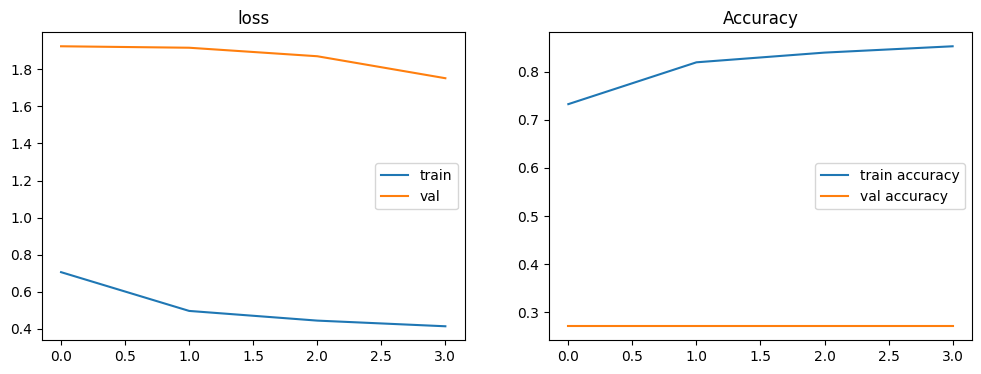

In [40]:
plot_history(history)